In [175]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [176]:
file = 'E:\data\european_cities_network\BE\BE_11001.parquet'
gdf = gpd.read_parquet(file)

In [177]:
gdf.head(3)

,u,v,path,osm_id,highway,level,lanes,width,bicycle,bicycle_safety,foot,foot_safety,max_speed,motorcar,geometry
edge_id,,,,,,,,,,,,,,,
4462,36705298,34675856,"[36705298, 36705297, 34675856]",5218134,tertiary,4,2,6.0,1,3,1,0,50,1,"LINESTRING (1797562.649 9328941.350, 1797561.3..."
7,1977621206,8025420595,"[1977621206, 8025420595]",5218134,tertiary,4,2,6.0,1,3,1,0,50,1,"LINESTRING (1797523.259 9328768.950, 1797524.8..."
4463,1977621206,36705298,"[1977621206, 36705301, 5143114855, 36705300, 5...",5218134,tertiary,4,2,6.0,1,3,1,0,50,1,"LINESTRING (1797556.351 9328883.109, 1797538.2..."


In [178]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1616 entries, 4462 to 5292
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   u               1616 non-null   int64   
 1   v               1616 non-null   int64   
 2   path            1616 non-null   object  
 3   osm_id          1616 non-null   object  
 4   highway         1616 non-null   object  
 5   level           1616 non-null   int64   
 6   lanes           1616 non-null   int64   
 7   width           1616 non-null   float64 
 8   bicycle         1616 non-null   int64   
 9   bicycle_safety  1616 non-null   int64   
 10  foot            1616 non-null   int64   
 11  foot_safety     1616 non-null   int64   
 12  max_speed       1616 non-null   int64   
 13  motorcar        1616 non-null   int64   
 14  geometry        1616 non-null   geometry
dtypes: float64(1), geometry(1), int64(10), object(3)
memory usage: 202.0+ KB


In [179]:
gdf.crs

<Derived Projected CRS: EPSG:3950>
Name: RGF93 / CC50
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - mainland north of 49°N
- bounds: (-2.03, 49.0, 8.08, 51.14)
Coordinate Operation:
- name: France Conic Conformal zone 9
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

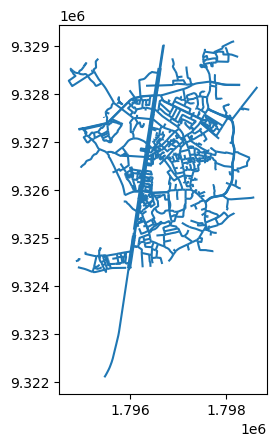

In [180]:
gdf.plot()

In [181]:
gdf.geometry.length.sum()

149717.12691833373

In [182]:
gdf.geometry.length.mean()

92.64673695441444

In [183]:
gdf['travel_time_in_s'] = gdf.geometry.length / (gdf.max_speed.where(gdf.max_speed != -1, 30) * 1000 / 3600)
gdf.travel_time_in_s.mean()

9.3241445997198

In [184]:
import networkx as nx
G = nx.Graph()
edges = gdf[['u','v','level']]
G.add_edges_from(list(edges[['u','v']].itertuples(index=False, name=None)),attr=list(edges.level))

In [185]:
largest_cc = max(nx.connected_components(G), key=len)
S = G.subgraph(largest_cc).copy()
pos=nx.spring_layout(S)

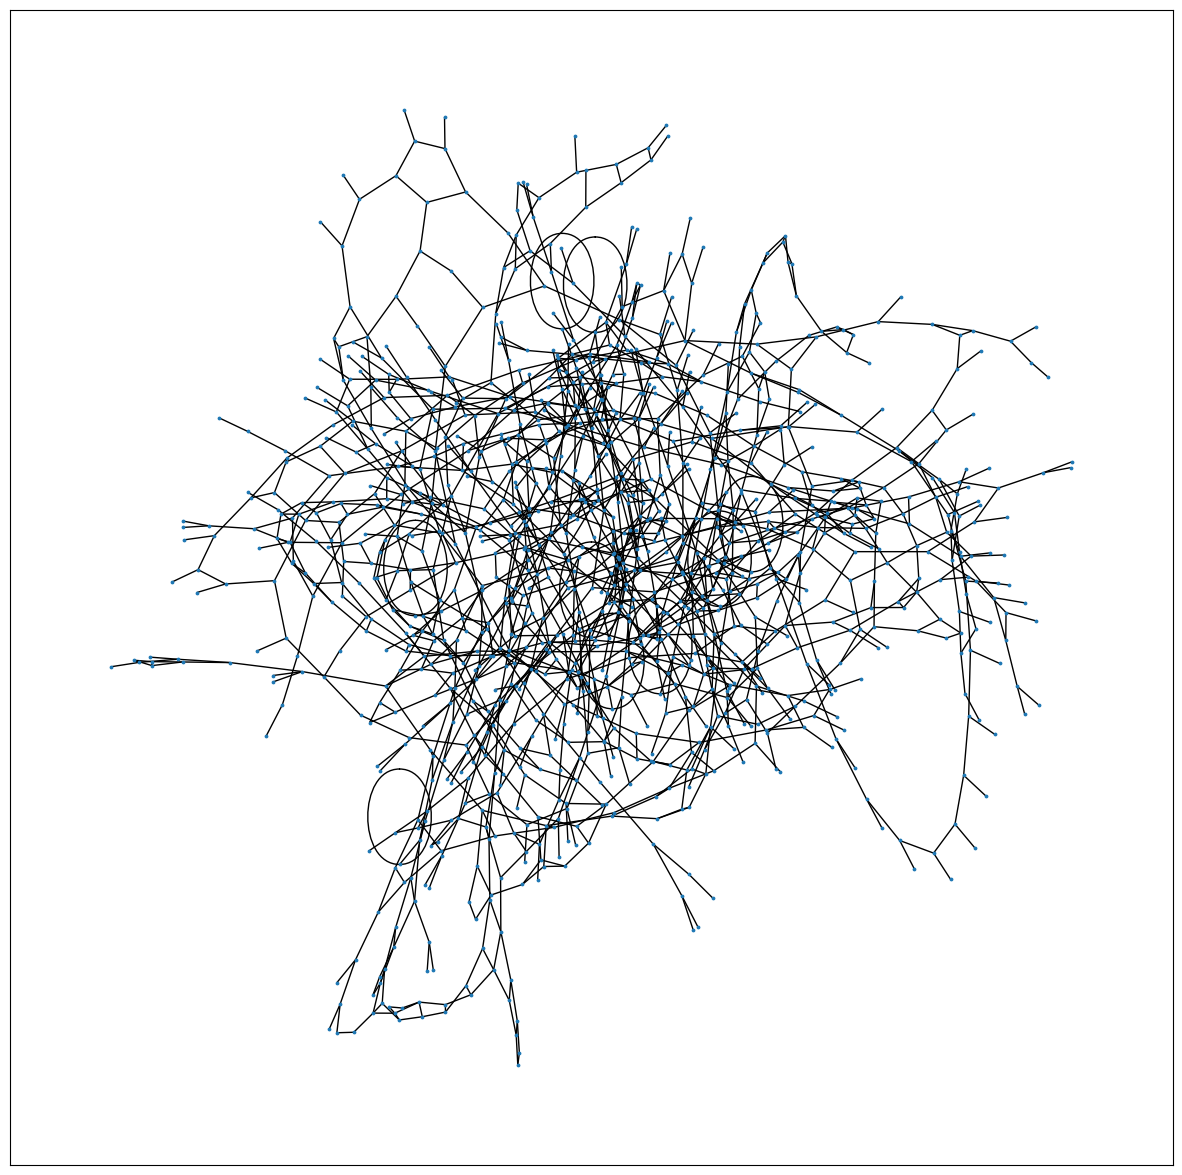

In [186]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
nx.draw_networkx(S, node_size=3, pos=pos, with_labels=False)

In [187]:
centrality = nx.eigenvector_centrality_numpy(G, weight='level')
se = pd.Series(data=centrality.values())

In [188]:
se.describe(percentiles=[.25, .5, .75, .9, .95, .99, .999])

count    1.209000e+03
mean     3.202002e-03
std      2.859289e-02
min     -7.511667e-18
25%      2.543264e-10
50%      4.498341e-09
75%      8.973805e-08
90%      7.963952e-06
95%      1.288079e-04
99%      1.240257e-01
99.9%    3.989621e-01
max      4.386175e-01
dtype: float64

In [189]:
A = nx.adjacency_matrix(G)
A.shape

(1209, 1209)

In [190]:
A.todense()

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [191]:
L = nx.laplacian_matrix(G)
L.shape

(1209, 1209)

In [192]:
D = L + A
D.todense()

array([[3, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 3, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 4]], dtype=int32)

In [193]:
L_n = nx.normalized_laplacian_matrix(G)
L_n.shape

(1209, 1209)

In [194]:
L_n.todense()

array([[ 1.  , -0.58, -0.33, ...,  0.  ,  0.  ,  0.  ],
       [-0.58,  1.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [-0.33,  0.  ,  1.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ]])

In [195]:
e = np.linalg.eigvals(L_n.todense())

In [196]:
e.shape

(1209,)

In [197]:
e

array([-1.42e-15+0.j,  2.00e+00+0.j,  1.99e+00+0.j, ...,  1.00e+00+0.j,
        1.00e+00+0.j,  1.00e+00+0.j])

In [198]:
max(e)

(2.0000000000000138+0j)

In [199]:
min(e)

(-1.423111093818778e-15+0j)

c:\users\yuxuan zhang\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\histograms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
c:\users\yuxuan zhang\appdata\local\programs\python\python39\lib\site-packages\matplotlib\transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


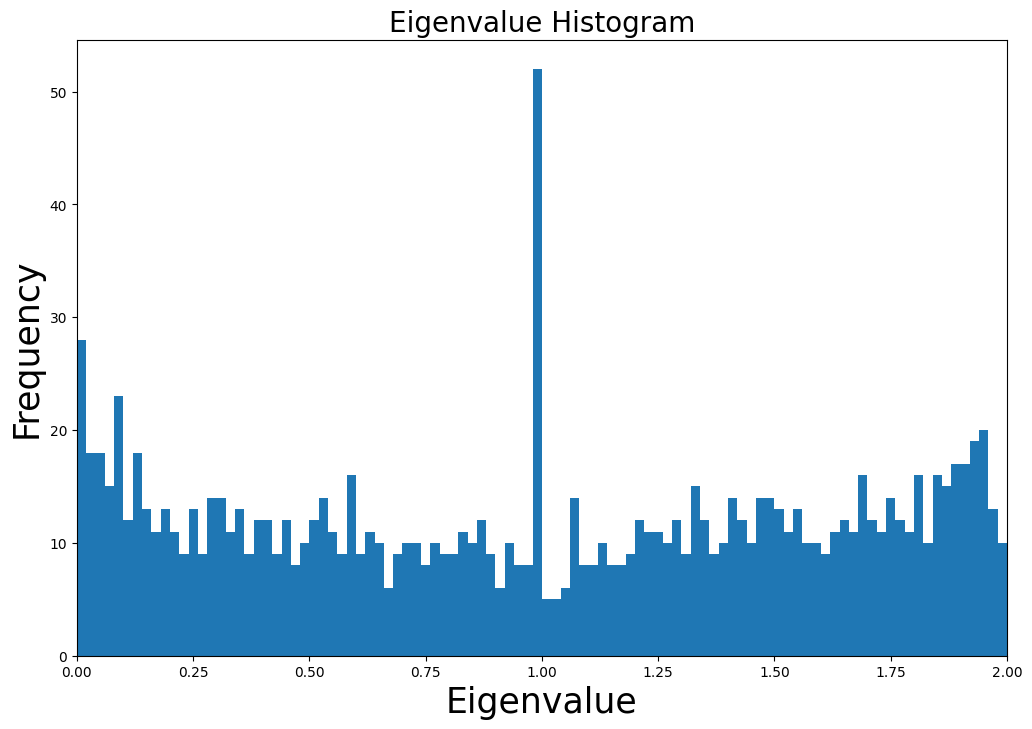

In [200]:
plt.figure(figsize=(12,8))

plt.hist(e, bins=100)
plt.xlim(0,2)

plt.title('Eigenvalue Histogram', fontsize=20)
plt.ylabel('Frequency', fontsize=25)
plt.xlabel('Eigenvalue', fontsize=25)
plt.show()